<h2 style="background-color:#166088;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 10px 10px;color:#dbe9ee">Welcome</h2>

<h4><center>This notebook is a simple sentiment analysis exercise. The aim is to have an introductory knowledge of NLP's "Data Preprocessing", "Bag Of Words" and "Machine Learning" steps</center></h4>

<h2 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:200%;text-align:left;border-radius: 7px 7px;color:#dbe9ee">Table Of Contents</h2>

* [Imports](#1)<br>


* [Data Preprocessing](#2)
    * [First Look](#16)
    * [Dictation](#3)
    * [Capitalization](#4)
    * [Stop Words / Corpus / Stemmer](#5)
    * [Implementation of all data](#6)<br>
    

    
* [Bag Of Words](#7)
    * [Count Vectorizer / Sparse Matrix](#8)
    

    
* [Machine Learning: Classification](#10)
    * [Naive Bayes](#11)
    * [Neural Networks](#12)
    * [XGBoost](#13)
    * [CatBoost](#14)
    * [SVC](#15)
    

    
* [Conclusion](#17)


<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Imports</h3><a id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re 
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Data Preprocessing</h3><a id="2"></a>

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">First Look</h3><a id="16"></a>



In [2]:
df = pd.read_csv("../input/reviews/Restaurant_Reviews.tsv",delimiter="\t")

In [3]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


* There 2 columns,
    * "Review" column shows reviews,<br>
    * "Liked" column gives information about their positive or negative reviews

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


* Dtypes looks good and it's nice that there is no missing value.

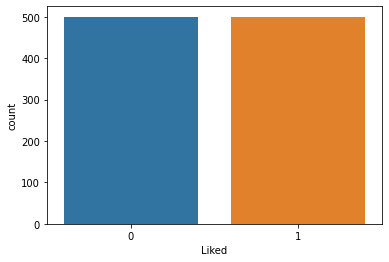

In [5]:
sns.countplot(x='Liked', data=df);

* The distribution of the dependent variable is important for the models to be built. Otherwise, there may be bias. The distribution is fine in this dataset.

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Dictation</h3><a id="3"></a>



<h5>Firstly, let's select a row to understand how it works</h5>

In [6]:
# Selected first row.
df["Review"][0]

'Wow... Loved this place.'

* An accurate and successful data pre-processing is important for us to develop successful ML models. Therefore, we need to clean up the characters we do not want in the reviews (things that will reduce the success of the model) and create clean data.

* Let's clear everything but words in our data (like punctuation)

In [7]:
review = re.sub("[^a-zA-Z]"," ",df["Review"][0])
review

'Wow    Loved this place '

> re.sub("[^a-zA-Z]"," ",df["Review"][0])

* **It Means:** Replace all non-[a-zA-Z] values in df["Review"][0] with " "
    * Here, we use the expression "^" to mean "non-[a-zA-Z]" ie: [^a-zA-Z]. This is used to say the opposite in python

In [8]:
print(f'Unclean review: {df["Review"][0]} \nClean review: {review}')

Unclean review: Wow... Loved this place. 
Clean review: Wow    Loved this place 


<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Capitalization</h3><a id="4"></a>

Capitalization isn't always a problem, and can sometimes contain important information for the feature.

For Example;

* i hate this product
* i HATE this product

We can think that these two sentences that are the same have different effects due to the use of capital letters.

But for our case, we will make all the words lowercase to learn how to use

In [9]:
# remember review
review

'Wow    Loved this place '

In [10]:
# let's check review's data-type
type(review)

str

In [11]:
# if review is a string-type, we can use string methods
review = review.lower()

In [12]:
# let's check
review

'wow    loved this place '

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Stop Words / Corpus / Stemmer</h3><a id="5"></a>

Removing stop words is important to create clean data. The reason for this is to better understand the value implied by the comment.

For Example;

* "i like this product"

When you remove the stop words from the sentence, it becomes "like product". and although these two sentences have the same meaning, the sentence without a stopword is a cleaner data

In [13]:
# We can download stopwords;

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Another important issue for clean data is to find the root of the word.

If we take the root of the word "liked", which is the verb of the sentence "I liked this product", it becomes "like" and it makes the data clean even if it doesn't change anything semantically



In [14]:
# We are preparing our data for the process we will do 
# by converting the string review variable into a list.
review = review.split()
review

['wow', 'loved', 'this', 'place']

In [15]:
ps = PorterStemmer()
review = [ps.stem(word) for word in review if not word in set(stopwords.words("english"))]

* **It means:** It creates a new list called review and there is no stop word in it. It also takes root words.

In [16]:
review

['wow', 'love', 'place']

In [17]:
print(f"""
unprocessed data: {df["Review"][0]}
preprocessed data: {" ".join(review)}
""")


unprocessed data: Wow... Loved this place.
preprocessed data: wow love place



* Although as you can see there is no semantic difference, the review looks cleaner now

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Implementation of all data</h3><a id="6"></a>

Now that we have explained what we want to do through a single review, we can now preprocess the entire dataset.

In [18]:
reviews = []
for i in range(len(df)):
    review = re.sub("[^a-zA-Z]"," ",df["Review"][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in str(stopwords.words("english"))]
    reviews.append(" ".join(review))

In [19]:
# Take a look 

reviews[:4]

['wow love place',
 'crust good',
 'tasti textur nasti',
 'stop late may bank holiday rick steve recommend love']

Up to the present;

* We cleaned reviews from unnecessary characters
* We have rooted the sentences

But; This does not mean that all our data is clean. Although it depends on the dataset, maybe dozens of more cleaning operations could be done even in this dataset. This notebook will not also mention all the details

<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Bag Of Words</h3><a id="7"></a>

We have finished the data preprocessing phase. The current stage is: "Bag Of Words"

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Count Vectorizer / Sparse Matrix</h3><a id="8"></a>

With "Count Vectorizer" we will create Sparse Matrix of reviews

In [20]:
cv = CountVectorizer(max_features = 1500)

In [21]:
# Select undependent variables and converting to array
X = cv.fit_transform(reviews).toarray()

In [22]:
# Sparse Matrix
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
# Shape | x: data, y: max_features (that we have defined)
X.shape 

(1000, 1500)

In [24]:
# Select dependent variables
y = df["Liked"].values

<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Machine Learning: Classification</h3><a id="10"></a>

Before we move on to the algorithms, we have to split our dataset into train/test

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [26]:
# to store accuracy scores
algorithms = {} 

<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Naive Bayes</h3><a id="11"></a>

In [27]:
nb_algorithms = [BernoulliNB,GaussianNB,MultinomialNB]
for algorithm in nb_algorithms:
    model = algorithm().fit(X_train,y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)

    
    print(f'=> Algorithm: {algorithm.__name__}\nConfusion Matrix:\n\n {cm} \n\nAccuracy Score: {accuracy_score(y_test,y_pred)}\n Classification Report:\n\n{classification_report(y_test,y_pred)}\n{"-"*25}')
    algorithms[algorithm.__name__] = accuracy_score(y_test,y_pred)

=> Algorithm: BernoulliNB
Confusion Matrix:

 [[73 24]
 [21 82]] 

Accuracy Score: 0.775
 Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        97
           1       0.77      0.80      0.78       103

    accuracy                           0.78       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.78      0.77       200

-------------------------
=> Algorithm: GaussianNB
Confusion Matrix:

 [[55 42]
 [12 91]] 

Accuracy Score: 0.73
 Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.57      0.67        97
           1       0.68      0.88      0.77       103

    accuracy                           0.73       200
   macro avg       0.75      0.73      0.72       200
weighted avg       0.75      0.73      0.72       200

-------------------------
=> Algorithm: MultinomialNB
Confusion Matrix:

 [[72 25]
 [21 82]] 


<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Neural Networks</h3><a id="12"></a>

In [28]:
mlpc_model = MLPClassifier(activation="logistic",max_iter=10000).fit(X_train,y_train)
y_pred = mlpc_model.predict(X_test)

In [29]:
algorithms["MLPClassifier"] = accuracy_score(y_test,y_pred)
print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.755


In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74        97
           1       0.75      0.78      0.77       103

    accuracy                           0.76       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.76      0.75       200



<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">XGBoost</h3><a id="13"></a>

In [31]:
xgb = XGBClassifier().fit(X_train,y_train)

y_pred = xgb.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:49:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
algorithms["XGBoost"] = accuracy_score(y_test,y_pred)

print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.7


In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.82      0.73        97
           1       0.78      0.58      0.67       103

    accuracy                           0.70       200
   macro avg       0.71      0.70      0.70       200
weighted avg       0.72      0.70      0.70       200



<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">CatBoost</h3><a id="14"></a>

In [34]:
catb = CatBoostClassifier().fit(X_train,y_train)
y_pred = catb.predict(X_test)
algorithms["CatBoost"] = accuracy_score(y_test,y_pred)

Learning rate set to 0.009366
0:	learn: 0.6915065	total: 62.4ms	remaining: 1m 2s
1:	learn: 0.6897495	total: 67.8ms	remaining: 33.8s
2:	learn: 0.6881722	total: 71.6ms	remaining: 23.8s
3:	learn: 0.6863600	total: 75ms	remaining: 18.7s
4:	learn: 0.6851619	total: 78.7ms	remaining: 15.7s
5:	learn: 0.6835759	total: 82.4ms	remaining: 13.7s
6:	learn: 0.6816692	total: 86.2ms	remaining: 12.2s
7:	learn: 0.6799870	total: 90.4ms	remaining: 11.2s
8:	learn: 0.6784495	total: 94.6ms	remaining: 10.4s
9:	learn: 0.6762375	total: 98.6ms	remaining: 9.76s
10:	learn: 0.6748916	total: 103ms	remaining: 9.23s
11:	learn: 0.6732266	total: 106ms	remaining: 8.76s
12:	learn: 0.6712406	total: 110ms	remaining: 8.37s
13:	learn: 0.6698501	total: 114ms	remaining: 8.03s
14:	learn: 0.6685275	total: 118ms	remaining: 7.76s
15:	learn: 0.6667387	total: 122ms	remaining: 7.5s
16:	learn: 0.6653045	total: 126ms	remaining: 7.29s
17:	learn: 0.6644790	total: 130ms	remaining: 7.08s
18:	learn: 0.6630956	total: 134ms	remaining: 6.91s
19:	

In [35]:
print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.75


<br> <br>

#### CatBoost: Model Tuning 

In [36]:
catb = CatBoostClassifier()

catb_params = {"learning_rate":[0.01,0.03,0.1],
              "iterations":[100,200,500],
              "depth":[4,5,8]}

catb_cv_model = GridSearchCV(catb, catb_params, cv=2, n_jobs=-1,verbose=2).fit(X_train,y_train,verbose=False)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.0min finished


In [37]:
catb_cv_model.best_params_

{'depth': 8, 'iterations': 100, 'learning_rate': 0.1}

In [38]:
catb_cv_model.best_score_

0.755

In [39]:
catb_tuned = CatBoostClassifier(learning_rate=catb_cv_model.best_params_["learning_rate"],
                           iterations=catb_cv_model.best_params_["iterations"],
                           depth=catb_cv_model.best_params_["depth"]).fit(X_train,y_train,verbose=False)

y_pred = catb_tuned.predict(X_test)

In [40]:
algorithms["CatBoost_Tuned"] = accuracy_score(y_test,y_pred)
print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.755


In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.93      0.79        97
           1       0.90      0.59      0.71       103

    accuracy                           0.76       200
   macro avg       0.79      0.76      0.75       200
weighted avg       0.79      0.76      0.75       200



<h3 style="background-color:#4A6FA5;font-family:newtimeroman;font-size:150%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">SVC</h3><a id="15"></a>

In [42]:
svm_model = SVC(kernel = "rbf").fit(X_train,y_train)
y_pred = svm_model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test,y_pred))
algorithms["SVC"] = accuracy_score(y_test,y_pred)

Accuracy Score: 0.735


<br> <br>

#### SVC: Model Tuning 

In [43]:
svm = SVC()
svm_params = {"C":np.arange(1,3),
             "kernel":["linear","rbf","sigmoid"]}
svm_cv_model = GridSearchCV(svm,svm_params,cv=3,verbose=2,n_jobs=-1).fit(X_train,y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.8s finished


In [44]:
svm_cv_model.best_params_

{'C': 2, 'kernel': 'rbf'}

In [45]:
svm_cv_model.best_score_

0.7724507898960886

In [46]:
svm_tuned = SVC(C=svm_cv_model.best_params_["C"],
               kernel=svm_cv_model.best_params_["kernel"]).fit(X_train,y_train)

y_pred = svm_tuned.predict(X_test)

In [47]:
algorithms["SVC_Tuned"] = accuracy_score(y_test,y_pred)
print("Accuracy Score:", accuracy_score(y_test,y_pred))

Accuracy Score: 0.77


In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79        97
           1       0.88      0.64      0.74       103

    accuracy                           0.77       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.79      0.77      0.77       200



<br> <br> <br>

<h3 style="background-color:#4F6D7A;font-family:newtimeroman;font-size:175%;text-align:left;border-radius: 5px 5px;color:#dbe9ee">Conclusion</h3><a id="17"></a>

#### Accuracy Scores of Algorithms;

In [49]:
algorithms

{'BernoulliNB': 0.775,
 'GaussianNB': 0.73,
 'MultinomialNB': 0.77,
 'MLPClassifier': 0.755,
 'XGBoost': 0.7,
 'CatBoost': 0.75,
 'CatBoost_Tuned': 0.755,
 'SVC': 0.735,
 'SVC_Tuned': 0.77}

Although the **"BernoulliNB"** algorithm has the highest **"Accuracy Score"**, this does not make it the best algorithm or the most successful model.

**Before starting an NLP or ML project**, goals are determined, actions are taken in line with these goals, and metrics are selected. I mean, the metrics to look at are project dependent.

**Data Preprocessing and Bag Of Words Stages** are very important in an NLP project. As this is a simple introductory notebook, these steps are not in-depth.

**More successful and accurate models can be developed** with much deeper and thoughtful Data Preprocessing, Bag Of Words And Machine Learning (Especially with Optimizations) Stages.

<h2 style="background-color:#166088;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 10px 10px;color:#dbe9ee">Thank you for reading</h2>

<center>
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/css/font-awesome.min.css">
<a href="https://www.linkedin.com/in/ardasamet/" class="social-icon si-rounded si-small si-linkedin">
  <i class="fa fa-linkedin">  LinkedIn</i>
</a>
</center>